## Test ML models
### h2o.ai
Transform netCDF serialized files to h2o dataframes via xarray and pandas.

In [57]:
# Load data
import sys
sys.path.append('../b_Temporal_Stack')
from regionstack import *
from eotempstack import *

from xr_eotemp import *

saldana = regionStack('Saldana_training_2015')

S1 object initialized from /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana_training_2015/pre/
Creation of new S1 stacks failed, reading existing stacks
Reading 4 S1 stack files
S1 object initialized from /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana_training_2015/pre/
Creation of new S1 stacks failed, reading existing stacks
Reading 3 S1 stack files
S2 object initialized from /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana_training_2015/pre/
Reading 3 S2 stack files
LE07 object initialized from /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana_training_2015/pre/
Reading 4 LE07 stack files
LC08 object initialized from /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asala

In [2]:
t_dir = '/mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana_training_2015/'
train_data = xr.open_mfdataset(t_dir+'training/train_temp.nc', chunks={'time':1})
train_data

<xarray.Dataset>
Dimensions:     (time: 19, x: 2981, y: 3635)
Coordinates:
  * time        (time) datetime64[ns] 2015-11-20 2015-11-27 2015-11-28 ...
  * y           (y) float64 4.122e+05 4.122e+05 4.122e+05 4.122e+05 ...
  * x           (x) float64 4.889e+05 4.889e+05 4.889e+05 4.889e+05 ...
    mask        (time, x, y) float64 dask.array<shape=(19, 2981, 3635), chunksize=(1, 2981, 3635)>
    class_mask  (time, x, y) int8 dask.array<shape=(19, 2981, 3635), chunksize=(1, 2981, 3635)>
Data variables:
    NDVI        (time, x, y) float32 dask.array<shape=(19, 2981, 3635), chunksize=(1, 2981, 3635)>
    LSWI        (time, x, y) float32 dask.array<shape=(19, 2981, 3635), chunksize=(1, 2981, 3635)>
    VV_ASC      (time, x, y) float32 dask.array<shape=(19, 2981, 3635), chunksize=(1, 2981, 3635)>
    VV_DSC      (time, x, y) float32 dask.array<shape=(19, 2981, 3635), chunksize=(1, 2981, 3635)>
    VH_DSC      (time, x, y) float32 dask.array<shape=(19, 2981, 3635), chunksize=(1, 2981, 3635)>


In [15]:
import h2o

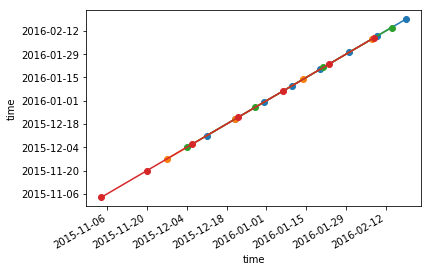

In [62]:
saldana.s2.time.plot(marker='o')
saldana.s1ASC.time.plot(marker='o')
saldana.s1DSC.time.plot(marker='o')
saldana.l8.time.plot(marker='o')

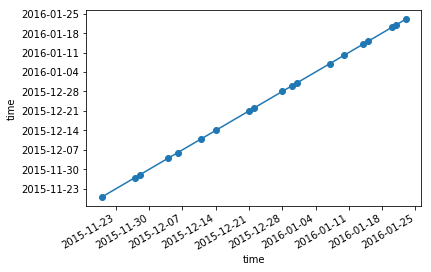

In [63]:
train_data.time.plot(marker='o')

In [10]:
sub = train_data.isel(time=slice(1,2))

In [16]:
# Initialize h2o cluster
h2o.init(nthreads = -1, max_mem_size = 8)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_121"; OpenJDK Runtime Environment (Zulu 8.20.0.5-linux64) (build 1.8.0_121-b15); OpenJDK 64-Bit Server VM (Zulu 8.20.0.5-linux64) (build 25.121-b15, mixed mode)
  Starting server from /home/azalazar/anaconda2/envs/models/h2o_jar/h2o.jar
  Ice root: /tmp/tmpRGV1Wr
  JVM stdout: /tmp/tmpRGV1Wr/h2o_azalazar_started_from_python.out
  JVM stderr: /tmp/tmpRGV1Wr/h2o_azalazar_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,06 secs
H2O cluster timezone:,America/Bogota
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.2
H2O cluster version age:,2 months and 23 days
H2O cluster name:,H2O_from_python_azalazar_84s9na
H2O cluster total nodes:,1
H2O cluster free memory:,7.111 Gb
H2O cluster total cores:,24
H2O cluster allowed cores:,24
H2O cluster status:,"accepting new members, healthy"


In [44]:
# Select only data from a date and transform to pandas dataframe
data_pd = sub.to_dask_dataframe()
# Leave only data with class
data_pd_v1 = data_pd.loc[data_pd['class'] > 0]
# Remove not valid data (cloudy pixels)
data_pd_v2 = data_pd_v1.loc[data_pd_v1['mask'] == True]

In [12]:
# Remove multi-index, as it is not preserved in h20
data_pd#_v2.reset_index(inplace=True)

,time,x,y,mask,class_mask,NDVI,LSWI,VV_ASC,VV_DSC,VH_DSC,class,NDVI_c,LSWI_c,VV_ASC_c,VV_DSC_c,VH_DSC_c
npartitions=1,,,,,,,,,,,,,,,,
0,datetime64[ns],float64,float64,float64,int8,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64
10835934,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [45]:
# Inspect dataframe
from dask.diagnostics import ProgressBar
from dask.dataframe import to_parquet
with ProgressBar():
    to_parquet(data_pd, t_dir[:-6]+'/parquet/')#train_temp-*.parquet')
    #data_pd.to_csv(, chunksize=10835935)

[########################################] | 100% Completed |  6.2s


In [30]:
t_dir[:-6]+'/parquet/'

'/mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana_training/parquet/'

In [46]:
from dask.dataframe import read_parquet

df = read_parquet(t_dir[:-6]+'/parquet/')
df

,time,x,y,mask,class_mask,NDVI,LSWI,VV_ASC,VV_DSC,VH_DSC,class,NDVI_c,LSWI_c,VV_ASC_c,VV_DSC_c,VH_DSC_c
npartitions=1,,,,,,,,,,,,,,,,
,datetime64[ns],float64,float64,float64,int8,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [52]:
# Load data to h2o frame
data = h2o.import_file(t_dir[:-6]+'/parquet/')  # 3764 rows x 14 columns
data.shape

Parse progress: |█████████████████████████████████████████████████████████| 100%


(10835935, 17)

In [48]:
data['class'] = data['class'].asfactor()  #encode the class response as a factor
data['class'].levels()  #after encoding, this shows the 5 factor levels, in this dataset '2' is missing!!!

[['0', '1', '2', '3', '4']]

In [54]:
data[data['class']==1]

time,x,y,mask,class_mask,NDVI,LSWI,VV_ASC,VV_DSC,VH_DSC,class,NDVI_c,LSWI_c,VV_ASC_c,VV_DSC_c,VH_DSC_c,__index_level_0__
1.44858e+15,512705,435065,nan,0,nan,nan,-6.64934,nan,nan,1,nan,nan,nan,nan,nan,8.66086e+06
1.44858e+15,512715,435045,nan,0,nan,nan,-8.41814,nan,nan,1,nan,nan,nan,nan,nan,8.66449e+06
1.44858e+15,512715,435055,nan,0,nan,nan,-8.20748,nan,nan,1,nan,nan,nan,nan,nan,8.6645e+06
1.44858e+15,512715,435065,nan,0,nan,nan,-8.28901,nan,nan,1,nan,nan,nan,nan,nan,8.6645e+06
1.44858e+15,512715,435075,nan,0,nan,nan,-6.97623,nan,nan,1,nan,nan,nan,nan,nan,8.6645e+06
1.44858e+15,512715,435085,nan,0,nan,nan,-6.05225,nan,nan,1,nan,nan,nan,nan,nan,8.6645e+06
1.44858e+15,512725,435035,nan,0,nan,nan,-7.58374,nan,nan,1,nan,nan,nan,nan,nan,8.66813e+06
1.44858e+15,512725,435045,nan,0,nan,nan,-9.51603,nan,nan,1,nan,nan,nan,nan,nan,8.66813e+06
1.44858e+15,512725,435055,nan,0,nan,nan,-9.39315,nan,nan,1,nan,nan,nan,nan,nan,8.66813e+06
1.44858e+15,512725,435065,nan,0,nan,nan,-10.1425,nan,nan,1,nan,nan,nan,nan,nan,8.66813e+06


In [14]:
# To train and test the model using only this data, split data
splits = data.split_frame(ratios=[0.7, 0.15], seed=1)
train = splits[0]
valid = splits[1]
test = splits[2]

In [15]:
# Show number of observations from each dataset
print train.nrow
print valid.nrow
print test.nrow

10416
2194
2195


In [34]:
# Define response variables and predictors
y = 'class'
x = list(data.columns)

In [37]:
# Show predictors
x

[u'time',
 u'NDVI',
 u'LSWI',
 u'VV_ASC',
 u'VV_DSC',
 u'VH_DSC',
 u'NDVI_c',
 u'LSWI_c',
 u'VV_ASC_c',
 u'VV_DSC_c',
 u'VH_DSC_c',
 u'__index_level_0__']

In [36]:
x.remove(y)  #remove the response
x.remove('x')
x.remove('y')
x.remove('mask')
x.remove('class_mask')
#x.remove('qa_cloud') #remove cloud mask

In [24]:
# test random forest
from h2o.estimators.random_forest import H2ORandomForestEstimator

In [25]:
# Initialize model
rf_v1 = H2ORandomForestEstimator(
    model_id="rf_covType_v1",
    ntrees=200,
    stopping_rounds=2,
    score_each_iteration=True,
    seed=1000000)

In [26]:
# Train model
rf_v1.train(x, y, training_frame=train, validation_frame=valid)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [27]:
# Print model details
rf_v1

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  rf_covType_v1


ModelMetricsMultinomial: drf
** Reported on train data. **

MSE: 0.0185147440009
RMSE: 0.136068894318
LogLoss: 0.248155309727
Mean Per-Class Error: 0.0158711588763
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



1,2,3,4,5,Error,Rate
1624.0,17.0,0.0,2.0,0.0,0.0115642,"19 / 1,643"
17.0,2483.0,13.0,7.0,0.0,0.0146825,"37 / 2,520"
0.0,21.0,3116.0,59.0,0.0,0.0250313,"80 / 3,196"
1.0,6.0,71.0,2700.0,0.0,0.0280778,"78 / 2,778"
0.0,0.0,0.0,0.0,253.0,0.0,0 / 253
1642.0,2527.0,3200.0,2768.0,253.0,0.0205967,"214 / 10,390"


Top-5 Hit Ratios: 


k,hit_ratio
1,0.9794033
2,0.9939365
3,0.9943215
4,0.9943215
5,1.0



ModelMetricsMultinomial: drf
** Reported on validation data. **

MSE: 0.0173065562876
RMSE: 0.131554385285
LogLoss: 0.145745072533
Mean Per-Class Error: 0.0179711204478
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



1,2,3,4,5,Error,Rate
303.0,4.0,0.0,0.0,0.0,0.0130293,4 / 307
4.0,522.0,6.0,1.0,0.0,0.0206379,11 / 533
1.0,4.0,693.0,3.0,0.0,0.0114123,8 / 701
2.0,6.0,19.0,576.0,0.0,0.0447761,27 / 603
0.0,0.0,0.0,0.0,50.0,0.0,0 / 50
310.0,536.0,718.0,580.0,50.0,0.0227894,"50 / 2,194"


Top-5 Hit Ratios: 


k,hit_ratio
1,0.9772106
2,0.9954422
3,0.9972653
4,0.9972653
5,1.0


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error,validation_rmse,validation_logloss,validation_classification_error
,2018-05-25 11:55:42,0.112 sec,0.0,nan,nan,nan,nan,nan,nan
,2018-05-25 11:55:43,0.699 sec,1.0,0.2068804,1.2501516,0.0432050,0.2020582,1.2427018,0.0446673
,2018-05-25 11:55:43,0.901 sec,2.0,0.2030344,1.1863168,0.0433665,0.1533008,0.4581514,0.0328168
,2018-05-25 11:55:43,1.029 sec,3.0,0.1925187,1.0032510,0.0396294,0.1392867,0.2609876,0.0255242
,2018-05-25 11:55:43,1.138 sec,4.0,0.1855294,0.8946803,0.0364648,0.1343581,0.1858522,0.0241568
,2018-05-25 11:55:44,1.255 sec,5.0,0.1774549,0.7730025,0.0334291,0.1352780,0.1736343,0.0264357
,2018-05-25 11:55:44,1.368 sec,6.0,0.1657641,0.6169585,0.0296666,0.1354310,0.1605909,0.0241568
,2018-05-25 11:55:44,1.490 sec,7.0,0.1589638,0.5263309,0.0271804,0.1355543,0.1471992,0.0237010
,2018-05-25 11:55:44,1.620 sec,8.0,0.1531156,0.4499150,0.0254121,0.1355379,0.1475452,0.0227894
,2018-05-25 11:55:44,1.730 sec,9.0,0.1481711,0.3937585,0.0242383,0.1339356,0.1459117,0.0227894


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
NDVI,13482.5810547,1.0,0.1765514
green,12154.0302734,0.9014617,0.1591543
red,11419.8876953,0.8470105,0.1495409
blue,10718.0283203,0.7949537,0.1403502
swir2,9294.8476562,0.6893968,0.1217140
swir1,6832.9711914,0.5067999,0.0894762
nir,6440.3427734,0.4776788,0.0843349
LSWI,6023.6264648,0.4467710,0.0788781


In [55]:
# Predict using test data
final_rf_predictions = rf_v1.predict(test[:-3])

drf prediction progress: |████████████████████████████████████████████████| 100%


In [64]:
test[:-3].nrow

2195

In [57]:
# Get test data accuracy
(final_rf_predictions['predict']==test['class']).as_data_frame(use_pandas=True).mean()

predict    0.978132
dtype: float64

In [31]:
# Shape of test data predictions
final_rf_predictions.as_data_frame().shape

(2195, 6)

In [32]:
final_rf_predictions['predict'].as_data_frame().shape

(2195, 1)

In [33]:
resulting_class_df = test.as_data_frame().join(final_rf_predictions['predict'].as_data_frame())

In [34]:
# Create MultiIndex from coordinates ## TODO include time!
resulting_class_df.set_index(['x', 'y'], inplace=True)

In [35]:
resulting_class_df.shape

(2195, 12)

In [36]:
# Test if duplicates (there shouldnt be!)
remove_duplicates = resulting_class_df[~resulting_class_df.index.duplicated(keep='first')]
remove_duplicates.shape

(2195, 12)

In [37]:
# Return to xarray
xarr = xr.Dataset.from_dataframe(resulting_class_df)

In [43]:
# Plot phenology class from test data. WHY IS IT LIKE THAT?!
xarr#['predict'].plot()

<xarray.Dataset>
Dimensions:     (x: 534, y: 552)
Coordinates:
  * x           (x) int64 499465 499485 499495 499505 499515 499525 499535 ...
  * y           (y) int64 424095 424105 424115 424125 424135 424145 424155 ...
Data variables:
    blue        (x, y) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    swir1       (x, y) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    swir2       (x, y) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    green       (x, y) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    nir         (x, y) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    NDVI        (x, y) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    LSWI        (x, y) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    red         (x, y) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    mask        (x, y) object nan nan nan nan nan nan nan nan nan nan nan ...
    class       (x, y) float64 nan nan nan nan nan na

In [44]:
# Prepare to compare initial with prediction
original = sat_data_again['class'].sel(time='2015-12-11').drop('time').drop('mask')
predicted = xarr['predict']

In [48]:
# Concatenate into one xarray
dimnames = xr.Variable('band', pd.Index(['class', 'predict']))
da = xr.concat([original.where(original>0).drop('class_mask'), predicted], dimnames)

In [49]:
da

<xarray.DataArray 'class' (band: 2, x: 2979, y: 3631)>
dask.array<shape=(2, 2979, 3631), dtype=float64, chunksize=(1, 2979, 3631)>
Coordinates:
  * y        (y) float64 4.122e+05 4.122e+05 4.122e+05 4.122e+05 4.122e+05 ...
  * x        (x) float64 4.889e+05 4.889e+05 4.889e+05 4.889e+05 4.889e+05 ...
  * band     (band) object 'class' 'predict'

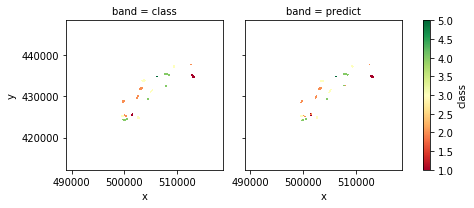

In [50]:
# Plot
da.plot(x='x', y='y', col='band', vmin=1., vmax=5., cmap='RdYlGn')

In [51]:
# Test merging into dataset
merged = xr.merge([original, predicted])
merged

<xarray.Dataset>
Dimensions:     (x: 2979, y: 3631)
Coordinates:
  * y           (y) float64 4.122e+05 4.122e+05 4.122e+05 4.122e+05 ...
  * x           (x) float64 4.889e+05 4.889e+05 4.889e+05 4.889e+05 ...
    class_mask  (x, y) bool dask.array<shape=(2979, 3631), chunksize=(2979, 3631)>
Data variables:
    class       (x, y) uint8 dask.array<shape=(2979, 3631), chunksize=(2979, 3631)>
    predict     (x, y) float64 nan nan nan nan nan nan nan nan nan nan nan ...

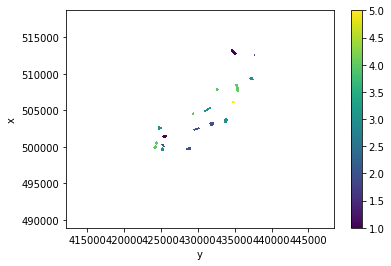

In [52]:
merged['class'].where(merged.class_mask).plot()

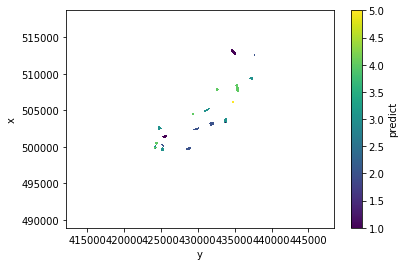

In [53]:
merged['predict'].plot()

In [64]:
# Close h2o cluster
h2o.cluster().shutdown(prompt=False)

H2O session _sid_9197 closed.


## Rest of h2o.ai tutorial

In [25]:
# Import H2O RF:
from h2o.estimators.random_forest import H2ORandomForestEstimator

In [26]:
# Initialize the RF estimator:

rf_fit1 = H2ORandomForestEstimator(model_id='rf_fit1', seed=1)

In [27]:
rf_fit1.train(x=x, y=y, training_frame=train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [28]:
rf_fit2 = H2ORandomForestEstimator(model_id='rf_fit2', ntrees=100, seed=1)
rf_fit2.train(x=x, y=y, training_frame=train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [29]:
rf_perf1 = rf_fit1.model_performance(test)
rf_perf2 = rf_fit2.model_performance(test)

In [30]:
print rf_perf1.auc()
print rf_perf2.auc()

0.663462768485
0.669287987873


In [31]:
rf_fit3 = H2ORandomForestEstimator(model_id='rf_fit3', seed=1, nfolds=5)
rf_fit3.train(x=x, y=y, training_frame=data)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [32]:
print rf_fit3.auc(xval=True)

0.663606041745


In [33]:
# Import H2O GBM:
from h2o.estimators.gbm import H2OGradientBoostingEstimator

In [34]:
# Initialize and train the GBM estimator:

gbm_fit1 = H2OGradientBoostingEstimator(model_id='gbm_fit1', seed=1)
gbm_fit1.train(x=x, y=y, training_frame=train)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [35]:
gbm_fit2 = H2OGradientBoostingEstimator(model_id='gbm_fit2', ntrees=500, seed=1)
gbm_fit2.train(x=x, y=y, training_frame=train)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [36]:
gbm_fit3 = H2OGradientBoostingEstimator(model_id='gbm_fit3', 
                                        ntrees=500, 
                                        score_tree_interval=5,     #used for early stopping
                                        stopping_rounds=3,         #used for early stopping
                                        stopping_metric='AUC',     #used for early stopping
                                        stopping_tolerance=0.0005, #used for early stopping
                                        seed=1)

# The use of a validation_frame is recommended with using early stopping
gbm_fit3.train(x=x, y=y, training_frame=train, validation_frame=valid)


gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [37]:
gbm_perf1 = gbm_fit1.model_performance(test)
gbm_perf2 = gbm_fit2.model_performance(test)
gbm_perf3 = gbm_fit3.model_performance(test)

In [38]:
# Retreive test set AUC
print gbm_perf1.auc()
print gbm_perf2.auc()
print gbm_perf3.auc()

0.683883128672
0.684086466361
0.684443511563


In [39]:
gbm_fit2.scoring_history()

Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_lift,training_classification_error
,2018-04-25 08:45:40,0.028 sec,0.0,0.3856346,0.4740298,0.5,1.0,0.8182546
,2018-04-25 08:45:40,0.128 sec,1.0,0.3837005,0.4691294,0.6577912,2.6832997,0.4006858
,2018-04-25 08:45:40,0.174 sec,2.0,0.3820620,0.4651166,0.6658294,2.7939915,0.3332492
,2018-04-25 08:45:40,0.221 sec,3.0,0.3806936,0.4618385,0.6685103,2.9710023,0.3447454
,2018-04-25 08:45:40,0.276 sec,4.0,0.3795380,0.4591170,0.6701132,2.9754401,0.3318046
---,---,---,---,---,---,---,---,---
,2018-04-25 08:45:43,3.795 sec,43.0,0.3677312,0.4317210,0.7124068,3.6410228,0.2975859
,2018-04-25 08:45:43,3.888 sec,44.0,0.3676187,0.4314625,0.7129225,3.6553764,0.3021722
,2018-04-25 08:45:44,3.989 sec,45.0,0.3674805,0.4311606,0.7134660,3.6649454,0.3023984
,2018-04-25 08:45:48,7.995 sec,226.0,0.3612902,0.4176954,0.7402357,4.2582264,0.2599471


In [40]:
# Import H2O DL:
from h2o.estimators.deeplearning import H2ODeepLearningEstimator

In [41]:
dl_fit1 = H2ODeepLearningEstimator(model_id='dl_fit1', seed=1)
dl_fit1.train(x=x, y=y, training_frame=train)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [42]:
dl_fit2 = H2ODeepLearningEstimator(model_id='dl_fit2', 
                                   epochs=20, 
                                   hidden=[10,10], 
                                   stopping_rounds=0,  #disable early stopping
                                   seed=1)
dl_fit2.train(x=x, y=y, training_frame=train)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [43]:
dl_fit3 = H2ODeepLearningEstimator(model_id='dl_fit3', 
                                   epochs=20, 
                                   hidden=[10,10],
                                   score_interval=1,          #used for early stopping
                                   stopping_rounds=3,         #used for early stopping
                                   stopping_metric='AUC',     #used for early stopping
                                   stopping_tolerance=0.0005, #used for early stopping
                                   seed=1)
dl_fit3.train(x=x, y=y, training_frame=train, validation_frame=valid)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [44]:
dl_perf1 = dl_fit1.model_performance(test)
dl_perf2 = dl_fit2.model_performance(test)
dl_perf3 = dl_fit3.model_performance(test)

In [45]:
# Retreive test set AUC
print dl_perf1.auc()
print dl_perf2.auc()
print dl_perf3.auc()

0.686254936726
0.681516110354
0.681802966019


In [47]:
from h2o.estimators.naive_bayes import H2ONaiveBayesEstimator
nb_fit1 = H2ONaiveBayesEstimator(model_id='nb_fit1')
nb_fit1.train(x=x, y=y, training_frame=train)

naivebayes Model Build progress: |████████████████████████████████████████| 100%


In [48]:
nb_fit2 = H2ONaiveBayesEstimator(model_id='nb_fit2', laplace=6)
nb_fit2.train(x=x, y=y, training_frame=train)

naivebayes Model Build progress: |████████████████████████████████████████| 100%


In [49]:
nb_perf1 = nb_fit1.model_performance(test)
nb_perf2 = nb_fit2.model_performance(test)

In [50]:
# Retreive test set AUC
print nb_perf1.auc()
print nb_perf2.auc()

0.651337099516
0.651391851824
